# Prediction of skin color of  soccer players

We formulate this task as a binary classification problem. Given a description of a particular soccer player we need to predict binary output: Y=1 (the player has dark skin) or Y=0 (the player has light skin)

We start with importing necessary libraries and loading the data into a dataframe for further analisys...

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, GroupShuffleSplit, cross_val_score

%matplotlib inline

In [37]:
def load_data():
    
    DATA_FILE_PATH = 'CrowdstormingDataJuly1st.csv'

    return pd.read_csv(DATA_FILE_PATH)

df = load_data()
    
df.shape

(146028, 28)

## Generating feature vectors and corresponding labels

We can see from the charts depicted below that occasionally raters disagree with each other. 

Therefore, to create a label for particular training example we will take an avarage of two raters. As far as the ratings range from 0 to 1 we can use a treshhold 0.5 to differentiate between dark and light skin. Specifically, we will consider Y=1 if the average rating is greater or equal to 0.5 and Y=0 otherwise.

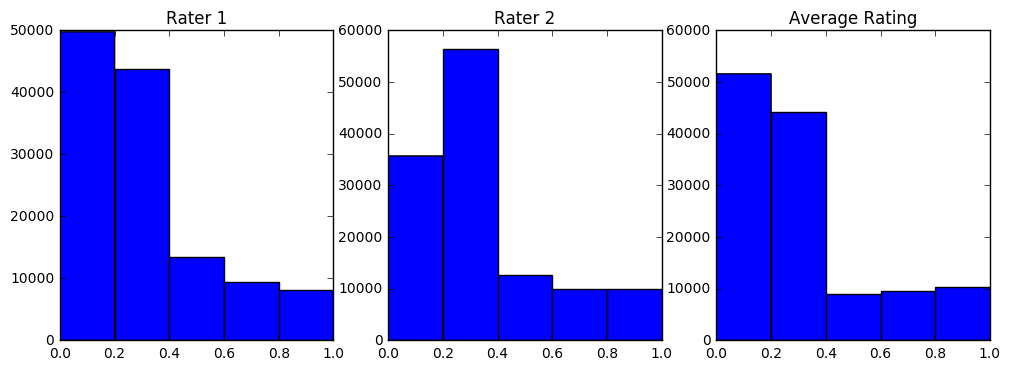

In [5]:
rates1, rates2, ratesAvg = df.rater1, df.rater2, (df.rater1 + df.rater2) / 2

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].hist(rates1.dropna(), bins=5)
ax[0].set_title('Rater 1')

ax[1].hist(rates2.dropna(), bins=5)
ax[1].set_title('Rater 2')

ax[2].hist(ratesAvg.dropna(), bins=5)
ax[2].set_title('Average Rating')

### Treating missing data

Below we display number of missing values per column (columns without na-s aren't displayed).

<ul>
<li>In case of numerical variables, we fill na-s with median.</li>
<li>In case of categorical variables, we fill na-s with the most frequent category.</li>
<li>We drop records with missing labels (rater1, rater2) because we can't do any predictions without correct labels. </li>
</ul>

<b>Note.</b> We show below that either both rater1 and rater2 values are present or missing. In other words, there are no such cases when only one of them is present/missing.

In [6]:
missingValCount = df.shape[0] - df.count()
missingValCount[missingValCount > 0]

height        263
weight       2243
position    17726
photoID     21407
rater1      21407
rater2      21407
Alpha_3         1
meanIAT       163
nIAT          163
seIAT         163
meanExp       163
nExp          163
seExp         163
dtype: int64

In [7]:
# The number of cases where one of the rates is present and the other is missing equals to zero.

np.sum(df.rater1.isnull() ^ df.rater2.isnull())

0

In [142]:
df = load_data()

# Removing rows with na-s in rater1 and rater2
df = df[~df.rater1.isnull()]

# Column names whith categorical values
cols_categorical = ["playerShort", "player", "club", "leagueCountry", "position", "photoID", "Alpha_3"]

# Converting categorical variables (string) into corresponding numerical codes (int). (Sklearn only accepts numerics).
for colName in cols_categorical:
    df[colName] = df[colName].astype('category').cat.codes
    
# Birthday is converted to age.
df['birthday'] = datetime.datetime.now().year - df['birthday'].str.rsplit('.', 1, True)[1].astype('int') 

# Generating labels by taking the average of two raters and converting to binary value.
Y = (((df.rater1 + df.rater2) / 2) >= 0.5).astype('int')

# We drop rater columns as they are used for labels and shouldn't be present in feature set as well.
X = df[df.columns.drop(['rater1', 'rater2'])]

# This list of groups id-s (single group is constituted by different records of a single player) to be used in cross validation
#below. We require training and test splits not to contain data about same players. 
# For more details, see Cross-validation iterators for grouped data (sklearn documentation).
groups = X['playerShort'].values

# Here we dismiss features which we considere to be unimportant. Indeed, one can't infer skin color according to name or photo id.
X = X[X.columns.drop(['playerShort', 'player', 'photoID', 'Alpha_3', 'club'])]

In [141]:
X.describe()

C:\Users\Sandro\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)
C:\Users\Sandro\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,...,yellowReds,redCards,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
count,124621.000000,124621.000000,124621.000000,124575.000000,123868.000000,124621.000000,124621.000000,124621.000000,124621.000000,124621.000000,...,124621.000000,124621.000000,124621.000000,124621.000000,124468.000000,1.244680e+05,1.244680e+05,124468.000000,1.244680e+05,124468.000000
mean,46.880437,1.532061,31.064146,182.125330,76.368102,3.892217,2.993613,1.342663,0.714968,0.935982,...,0.012061,0.012751,1531.111546,29.488096,0.348123,1.817187e+04,6.287461e-04,0.463797,1.884147e+04,0.002988
std,28.181686,1.145214,4.390313,6.804843,7.188595,3.408650,3.580429,1.879913,1.143873,1.422906,...,0.111052,0.113901,916.314559,27.963752,0.032087,1.261437e+05,4.788647e-03,0.219206,1.296022e+05,0.019719
min,0.000000,0.000000,20.000000,161.000000,54.000000,-1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,-0.047254,2.000000e+00,2.235373e-07,-1.375000,2.000000e+00,0.000001
25%,25.000000,0.000000,28.000000,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,652.000000,7.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,45.000000,2.000000,31.000000,NaN,NaN,4.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,1574.000000,15.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,70.000000,2.000000,34.000000,NaN,NaN,6.000000,3.000000,2.000000,1.000000,1.000000,...,0.000000,0.000000,2332.000000,45.000000,NaN,NaN,NaN,NaN,NaN,NaN
max,96.000000,3.000000,45.000000,203.000000,100.000000,11.000000,47.000000,29.000000,14.000000,18.000000,...,3.000000,2.000000,3147.000000,161.000000,0.573793,1.975803e+06,2.862871e-01,1.800000,2.029548e+06,1.060660


In [143]:
pipeline = Pipeline([('fillna_numeric', Imputer(missing_values='NaN', strategy='median', axis=0)),
                     ('fillna_categorical', Imputer(missing_values=-1, strategy='most_frequent', axis=0)),
                     ('standardize', StandardScaler()), 
                     ('rf', RandomForestClassifier(n_jobs=-1, n_estimators=10, max_features='log2'))
                    ])

cv = cross_val_score(pipeline, X, Y, groups, n_jobs=-1, cv=GroupShuffleSplit(n_splits=10, test_size=0.2))

### Cross validation for selecting best hyperparameters

Below we use grid search to find best combination of hyperparameters out of the predefined range.

In [191]:
# number of decision trees in a random forest 
num_trees = list(range(1, 25))

param_grid = dict(rf__n_estimators = num_trees)

In [193]:
# we use pipeline to simplify handling missing values and data normalizaion

pipeline = Pipeline([('fillna_numeric', Imputer(missing_values='NaN', strategy='median', axis=0)),
                     ('fillna_categorical', Imputer(missing_values=-1, strategy='most_frequent', axis=0)),
                     ('standardize', StandardScaler()), 
                     ('rf', RandomForestClassifier(n_jobs=-1))
                    ])

grid = GridSearchCV(pipeline, param_grid, n_jobs= -1,
                    cv = GroupShuffleSplit(n_splits=20, test_size=0.2))

In [194]:
grid.fit(X, Y, groups)

GridSearchCV(cv=GroupShuffleSplit(n_splits=20, random_state=None, test_size=0.2,
         train_size=None),
       error_score='raise',
       estimator=Pipeline(steps=[('fillna_numeric', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('fillna_categorical', Imputer(axis=0, copy=True, missing_values=-1, strategy='most_frequent',
    verbose=0)), ('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf',...mators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'rf__n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [195]:
grid.best_score_, grid.best_params_

(0.75248869507742155, {'rf__n_estimators': 24})

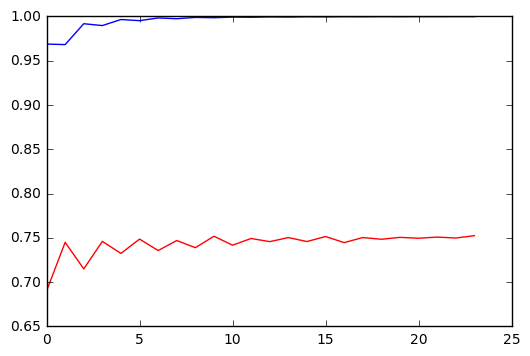

In [200]:
trainScores = grid.cv_results_['mean_train_score']
testScores = grid.cv_results_['mean_test_score']

plt.plot(trainScores)
plt.plot(testScores, c='red')